In [1]:
%pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=0162e31a4c6f20de49fe08543ac716c471462d092385738c40e3e1c48144169b
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [2]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
df = pd.read_csv('Demographic_Data_Orig.csv')

In [4]:
df.isnull().sum()

index             0
full.name         0
ip.address    40000
region            0
in.store          0
age               0
items             0
amount            0
dtype: int64

In [5]:
df.head()

,index,full.name,ip.address,region,in.store,age,items,amount
0,0,Carter Stokes,NaN,2,0,37,4,281.03
1,1,Jacob Jerde,NaN,2,0,35,2,219.51
2,2,Tressa Ratke,192.90.208.202,4,1,45,3,1525.70
3,3,Rudolf Abshire,251.55.128.164,3,1,46,3,715.25
4,4,Theresa Davis,182.19.192.186,1,1,33,4,1937.50


In [6]:
df.columns

Index(['index', 'full.name', 'ip.address', 'region', 'in.store', 'age',
       'items', 'amount'],
      dtype='object')

In [7]:
df.drop(columns=['ip.address', 'full.name'], axis=1, inplace=True)

In [13]:
selected_columns = ['region', 'in.store', 'age', 'items', 'amount']
df_selected = df[selected_columns]
X = df_selected.drop('amount', axis=1)
y = df_selected['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
import h2o

# Start H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp85y2oitj
  JVM stdout: /tmp/tmp85y2oitj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp85y2oitj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_unknownUser_2i0hxt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [9]:
# Convert the Pandas DataFrame to an H2O Frame
h2o_df = h2o.H2OFrame(df)

# Identify predictors and response
x = h2o_df.columns[:-1]
y = 'amount'

# For binary classification, response should be a factor

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_runtime_secs=3600)
aml.train(x=x, y=y, training_frame=h2o_df)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
best_model = h2o.get_model(aml.leaderboard[0, 'model_id'])
print("Best Model:")
print(best_model)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Best Model:
Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20240210_124642


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       9/143
# GBM base models (used / total)           4/88
# XGBoost base models (used / total)       1/42
# DeepLearning base models (used / total)  4/10
# DRF base models (used / total)           0/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on 

In [11]:
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20240210_124642,534.763,285971,399.296,0.831919,285971
StackedEnsemble_BestOfFamily_4_AutoML_1_20240210_124642,534.794,286005,399.344,0.832093,286005
StackedEnsemble_AllModels_4_AutoML_1_20240210_124642,534.795,286006,399.306,0.831901,286006
GBM_grid_1_AutoML_1_20240210_124642_model_42,534.831,286044,399.393,0.835031,286044
XGBoost_lr_search_selection_AutoML_1_20240210_124642_select_grid_model_2,534.89,286107,399.108,0.830476,286107
GBM_grid_1_AutoML_1_20240210_124642_model_5,535.186,286424,399.599,0.836103,286424
XGBoost_grid_1_AutoML_1_20240210_124642_model_10,535.272,286516,399.706,0.8344,286516
GBM_grid_1_AutoML_1_20240210_124642_model_22,535.293,286538,399.647,0.836747,286538
XGBoost_grid_1_AutoML_1_20240210_124642_model_24,535.297,286543,399.726,0.834139,286543
GBM_grid_1_AutoML_1_20240210_124642_model_81,535.353,286603,399.645,0.837374,286603


In [12]:
best_gbm_model_id = 'GBM_grid_1_AutoML_1_20240210_124642_model_42'
best_gbm_model = h2o.get_model(best_gbm_model_id)


In [13]:
best_gbm_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20240210_124642_model_42


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          10775                  0            4            3.2           1             16            12.48

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 284851.9097766597
RMSE: 533.7151953773283
MAE: 398.62303433124424
RMSLE: 0.8339652611919144
Mean Residual Deviance: 284851.9097766597

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 286043.7339007337
RMSE: 534.8305656006711
MAE: 399.3932474832772
RMSLE: 0.8350306681499351
Mean Residual Deviance: 286043.7339007337

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     399.393   1.54092     399.654       401.004       399.296       396.886       400.126
mean_residual_deviance  286044    1549.52     285017        288161        285796        284271        286973
mse                     286044    1549.52     285017        288161        285796        284271        286973
r2                      0.450078  0.00555781  0.447454      0.454011      0.457537      0.443807      0.44758
residual_deviance       286044    1549.52     285017        288161        285796        284271        286973
rmse                    534.829   1.44813     533.87        536.807       534.599       533.171       535.699
rmsle                   0.835024  0.00380253  0.840263      0.83595       0.831519      0.836311      0.831076

Scoring History: 
    timestamp            duration           number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  -----------------  -----------------  ---------------  --------------  -------------------
    2024-02-10 13:12:01  10 min 11.938 sec  0                  721.269          580.765         520229
    2024-02-10 13:12:01  10 min 12.057 sec  5                  606.047          477.79          367293
    2024-02-10 13:12:01  10 min 12.163 sec  10                 560.263          428.284         313894
    2024-02-10 13:12:01  10 min 12.271 sec  15                 543.35           409.303         295229
    2024-02-10 13:12:01  10 min 12.383 sec  20                 537.257          402.545         288645
    2024-02-10 13:12:01  10 min 12.487 sec  25                 535.083          400.129         286314
    2024-02-10 13:12:02  10 min 12.602 sec  30                 534.295          399.22          285471
    2024-02-10 13:12:02  10 min 12.708 sec  35                 533.959          398.857         285112
    2024-02-10 13:12:02  10 min 12.811 sec  40                 533.715          398.623         284852
    2024-02-10 13:12:02  10 min 12.850 sec  45                 533.715          398.623         284852
    2024-02-10 13:12:02  10 min 12.895 sec  50                 533.715          398.623         284852

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
region      6.11884e+10            1                    0.690905
in.store    2.58359e+10            0.422235             0.291724
age         1.2106e+09             0.0197848            0.0136694
index       2.57357e+08            0.00420597           0.00290593
items       7.05067e+07            0.00115229           0.000796122

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.displa

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

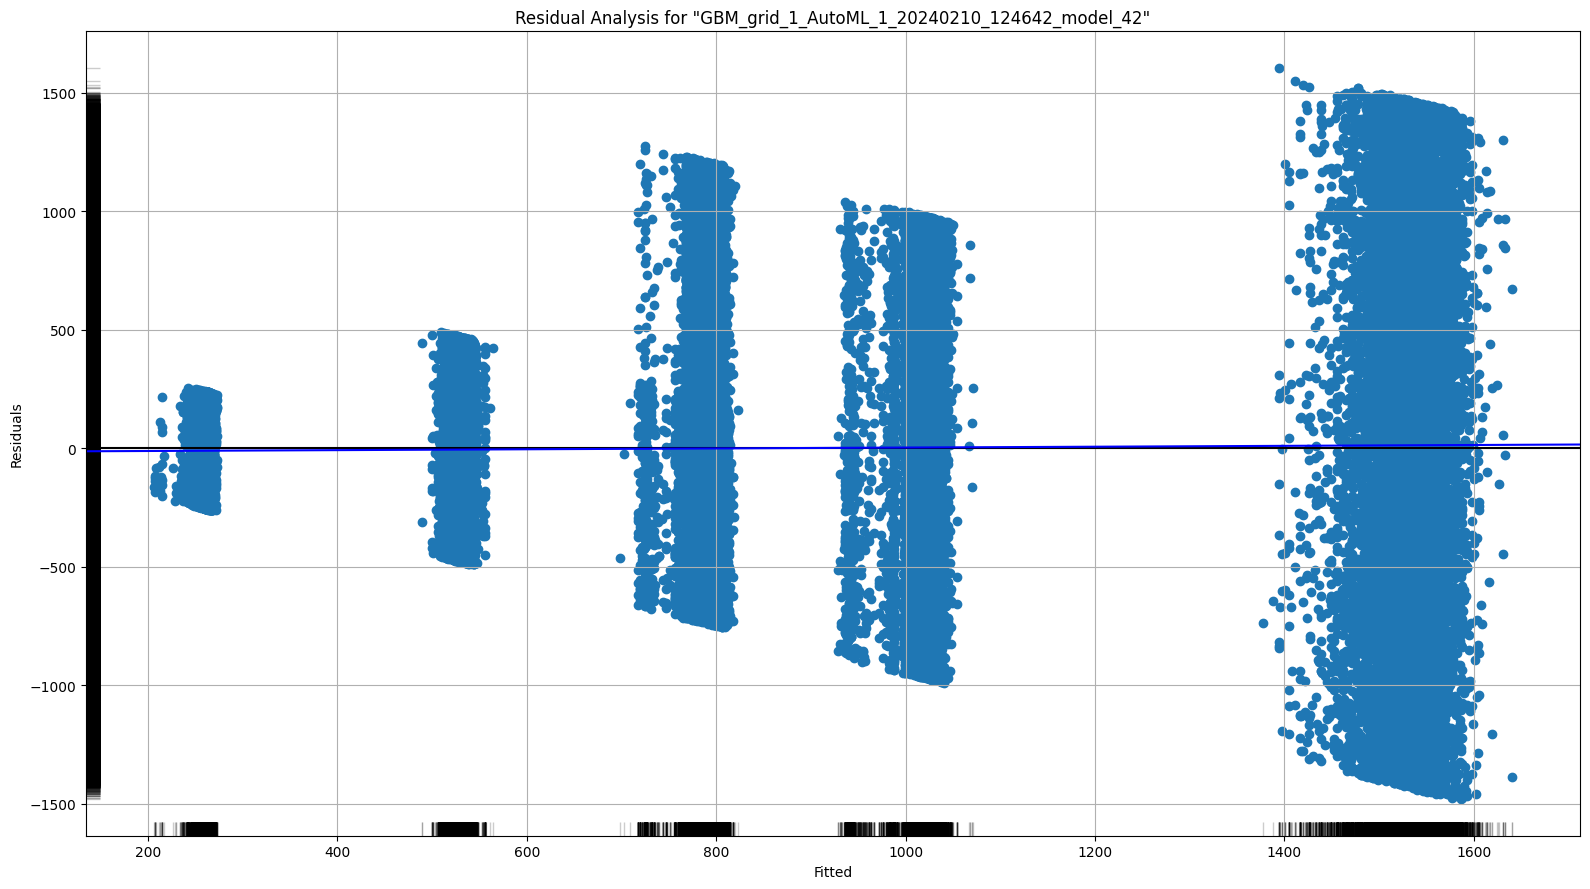

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

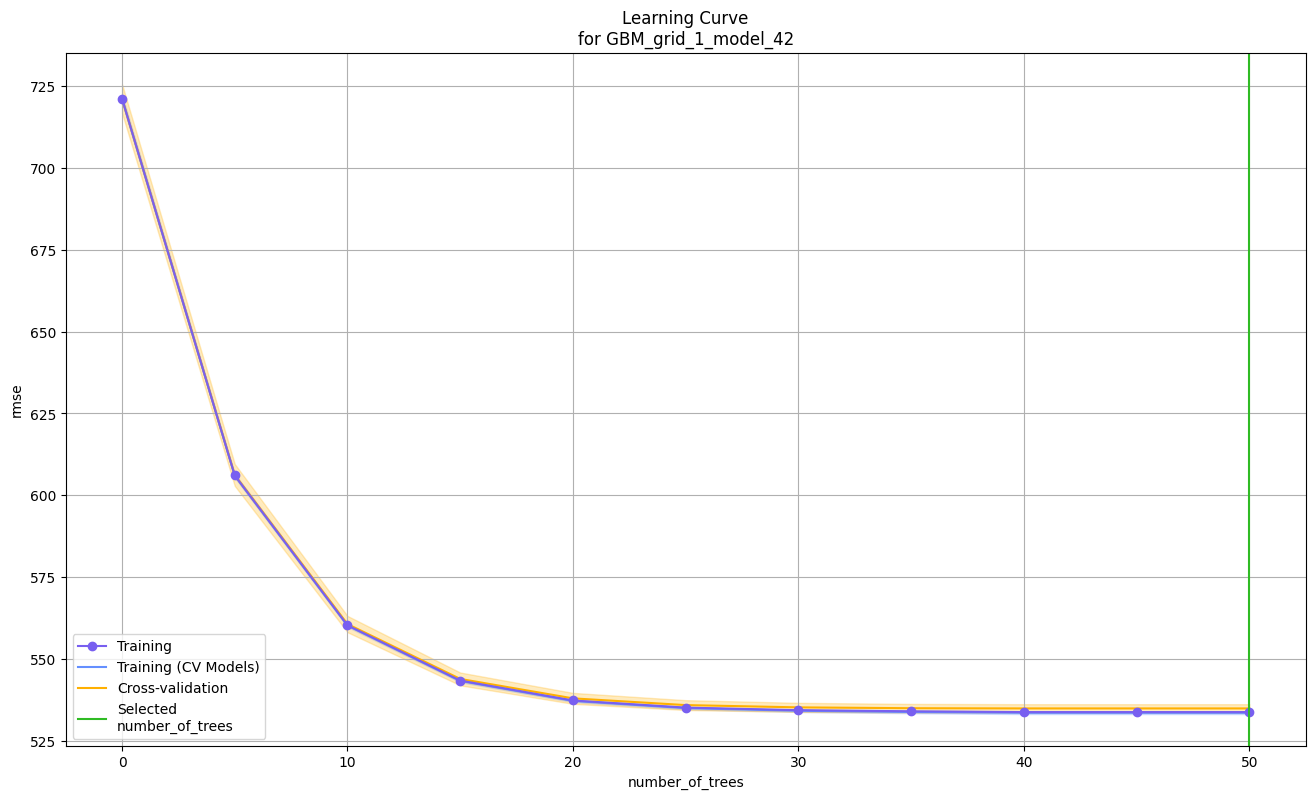

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

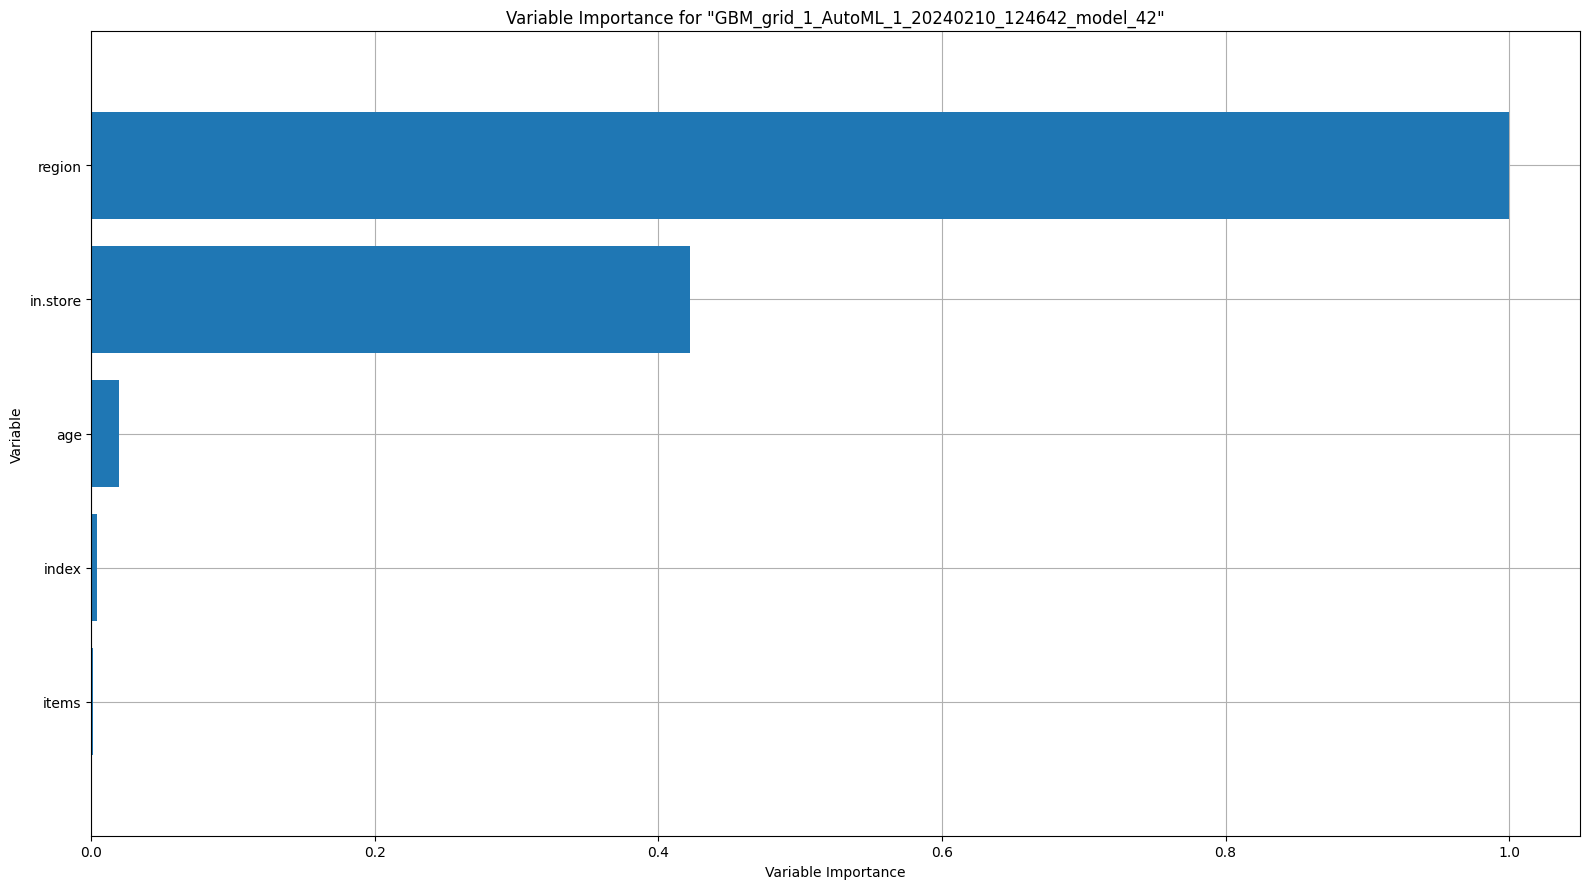

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

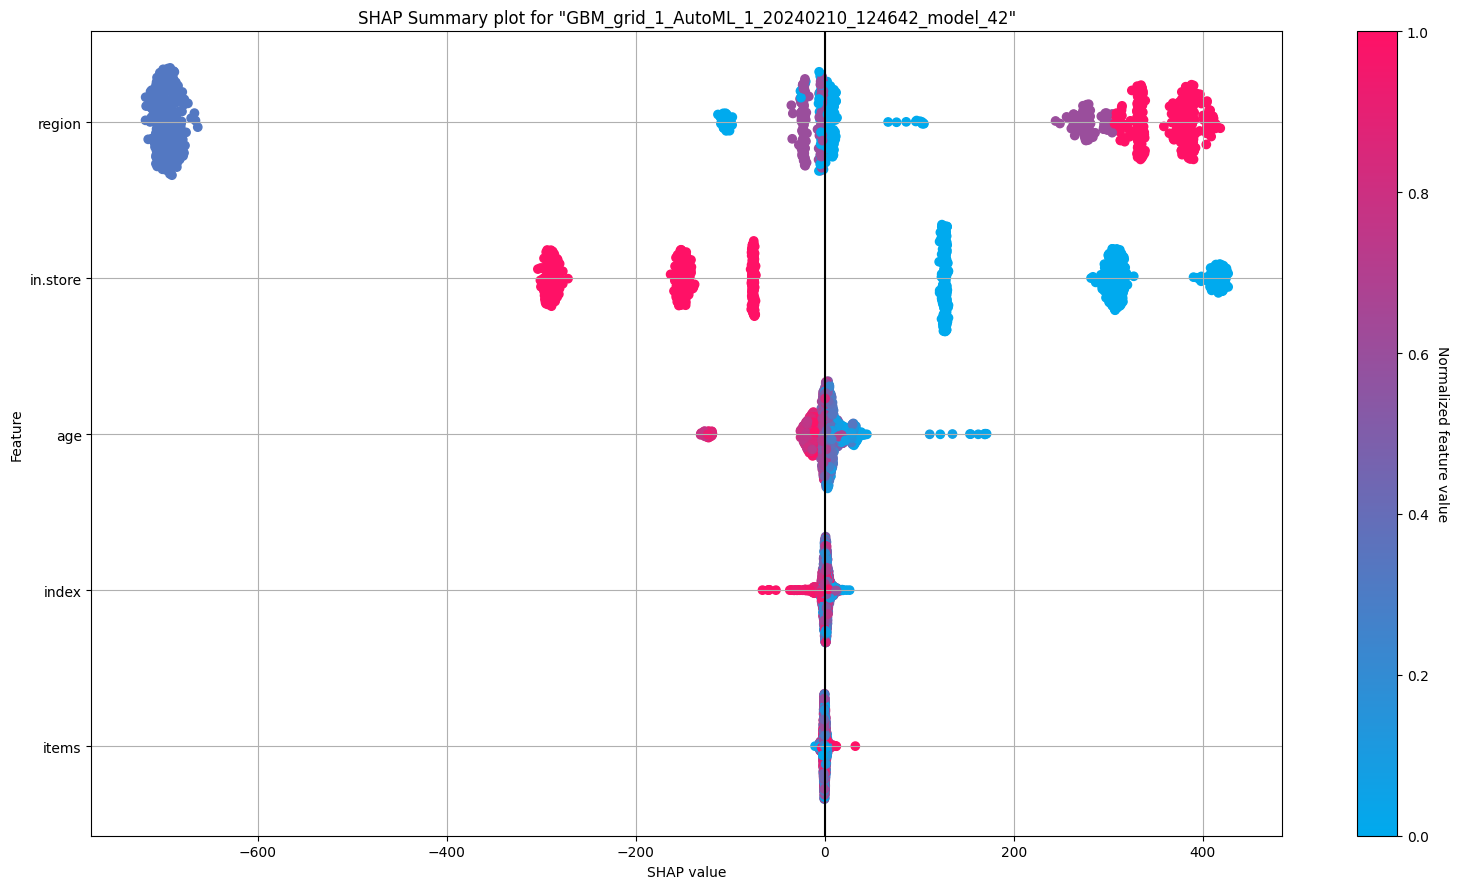

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

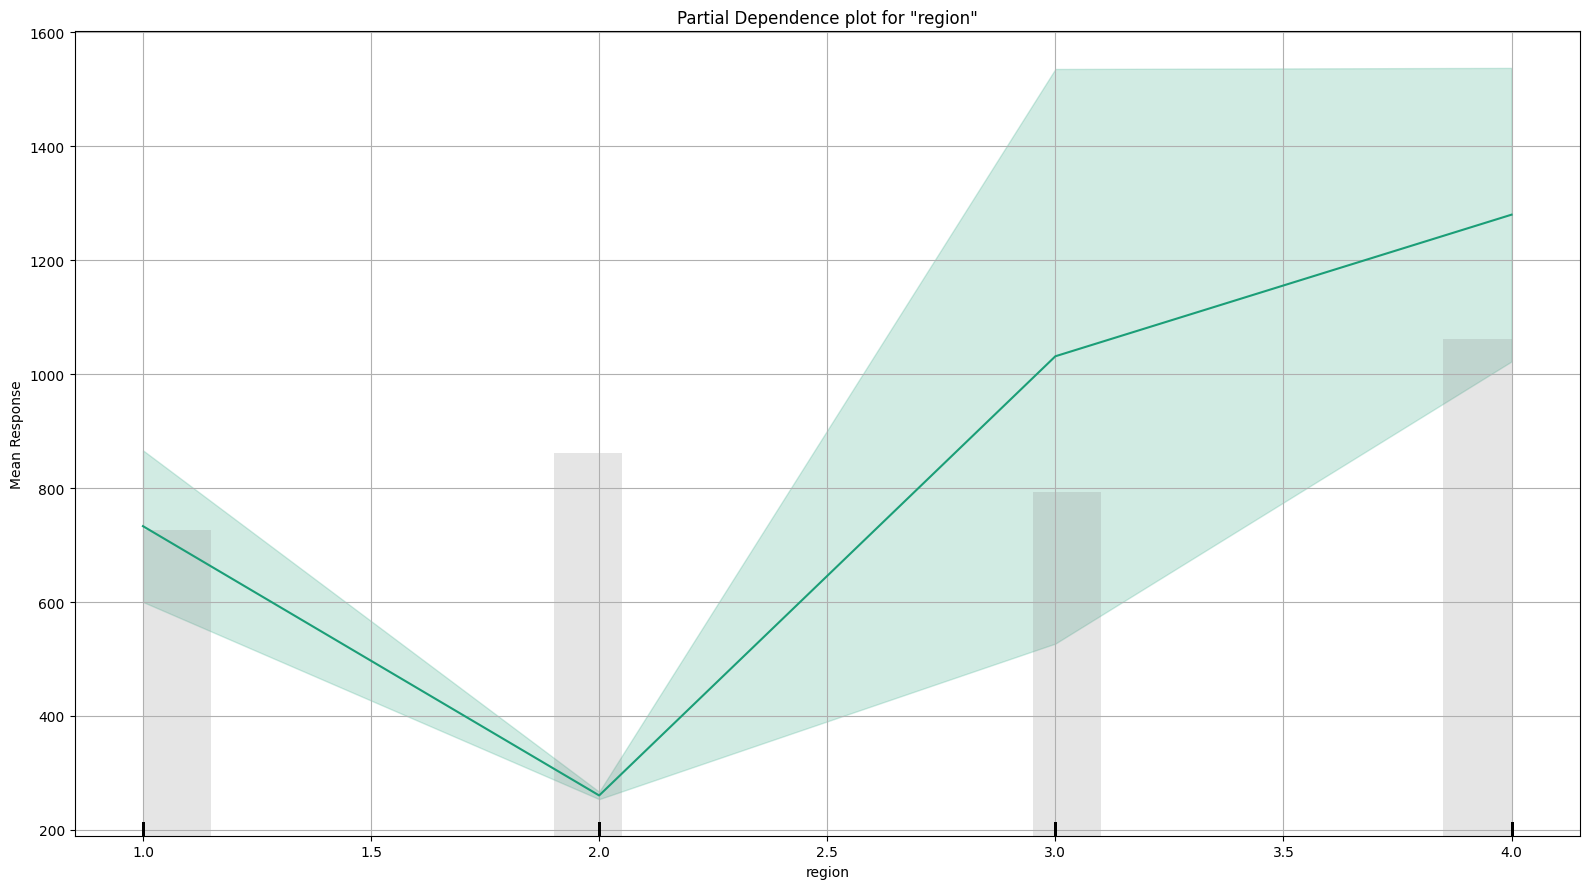

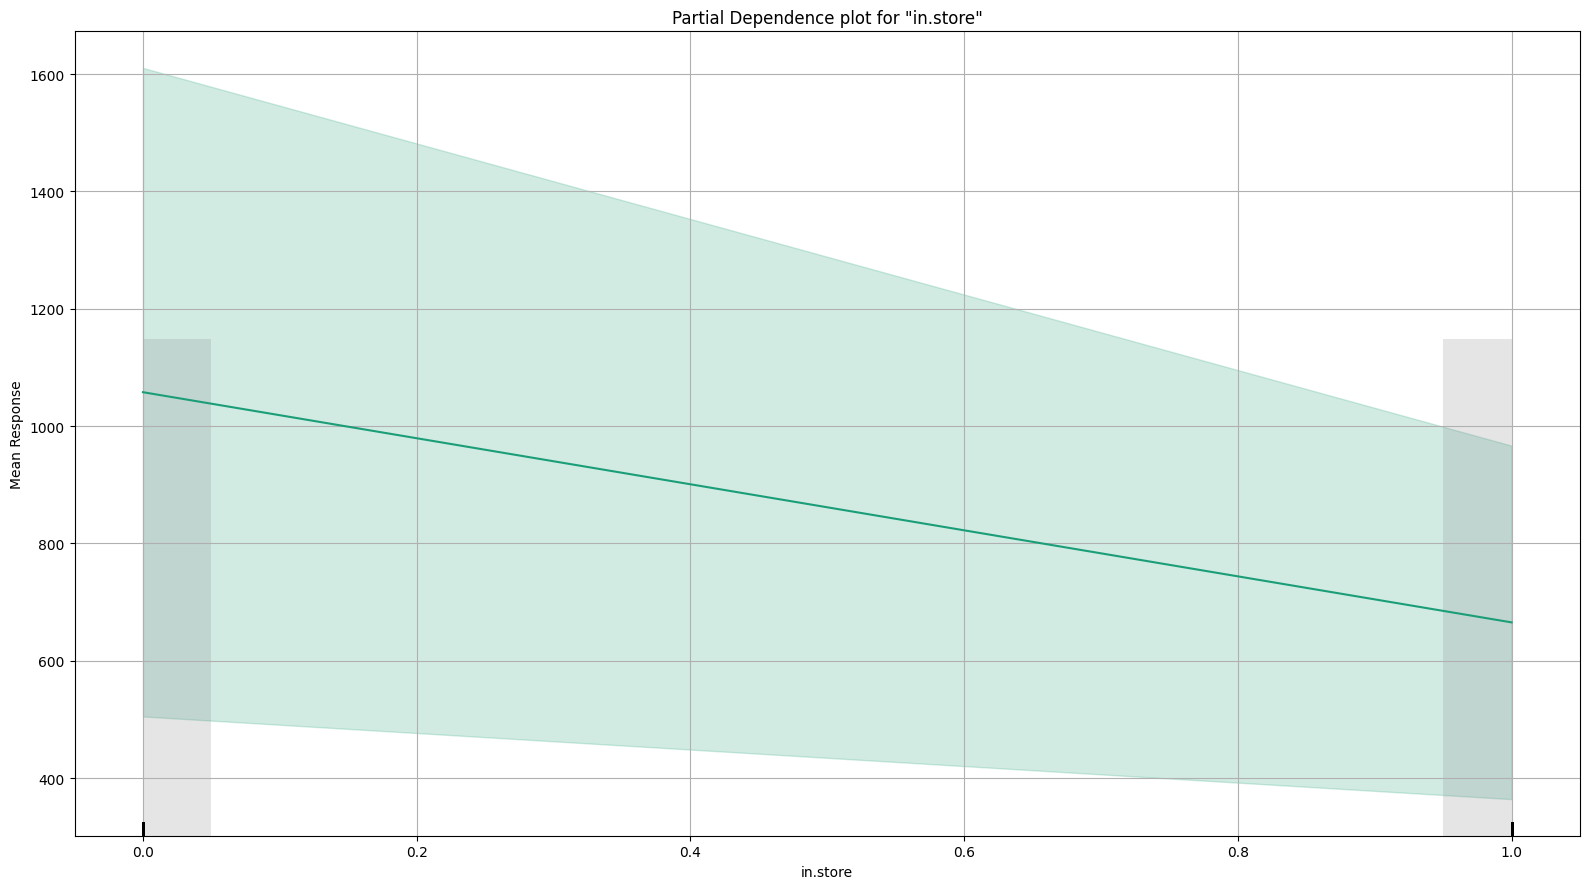

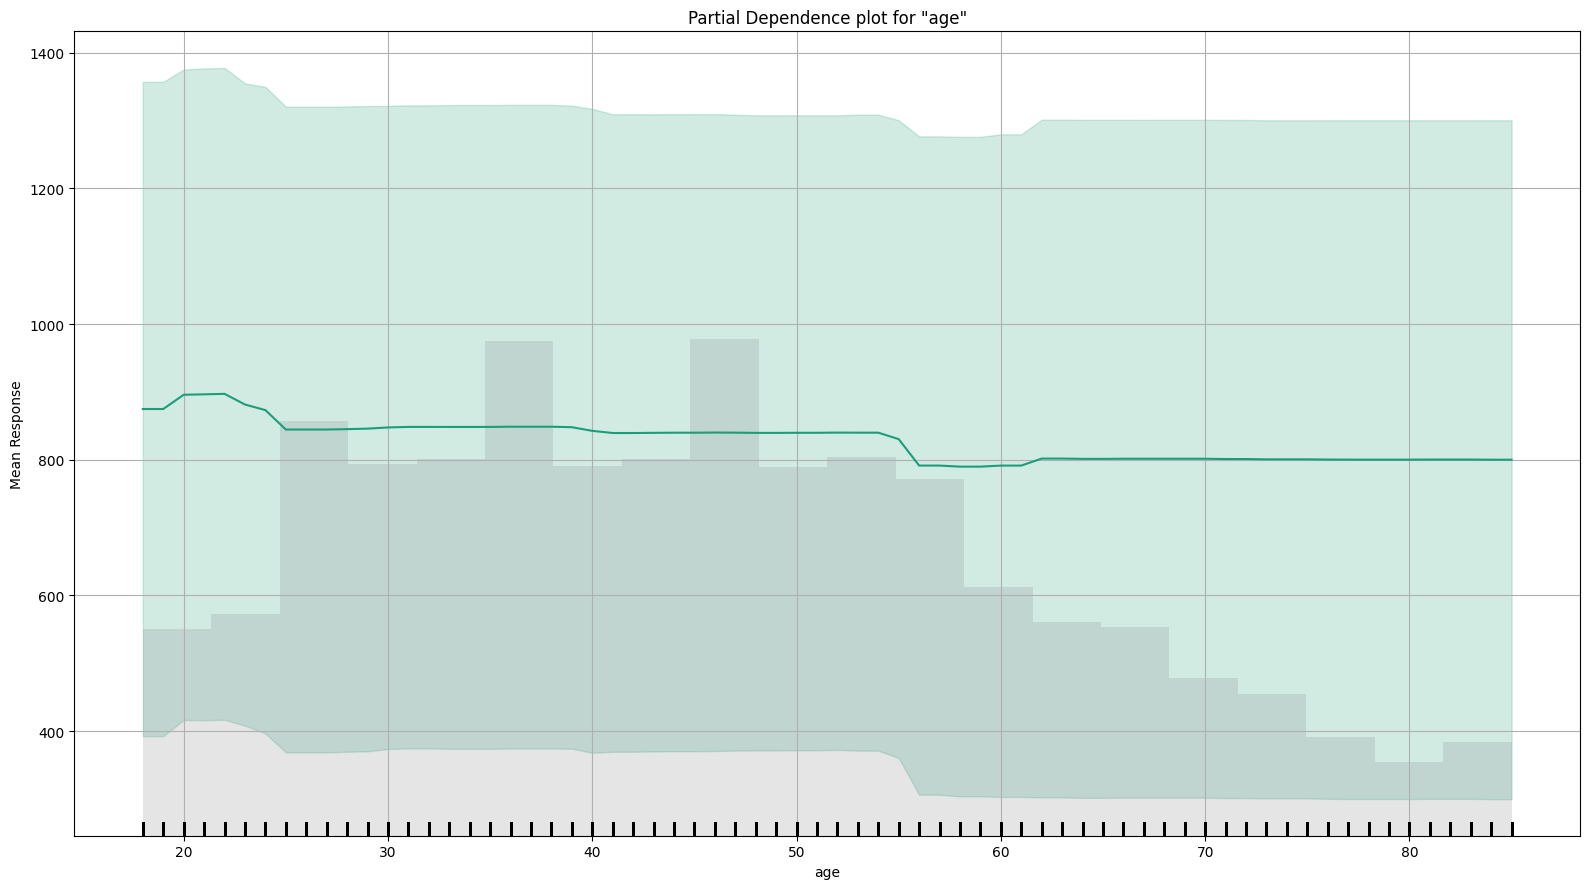

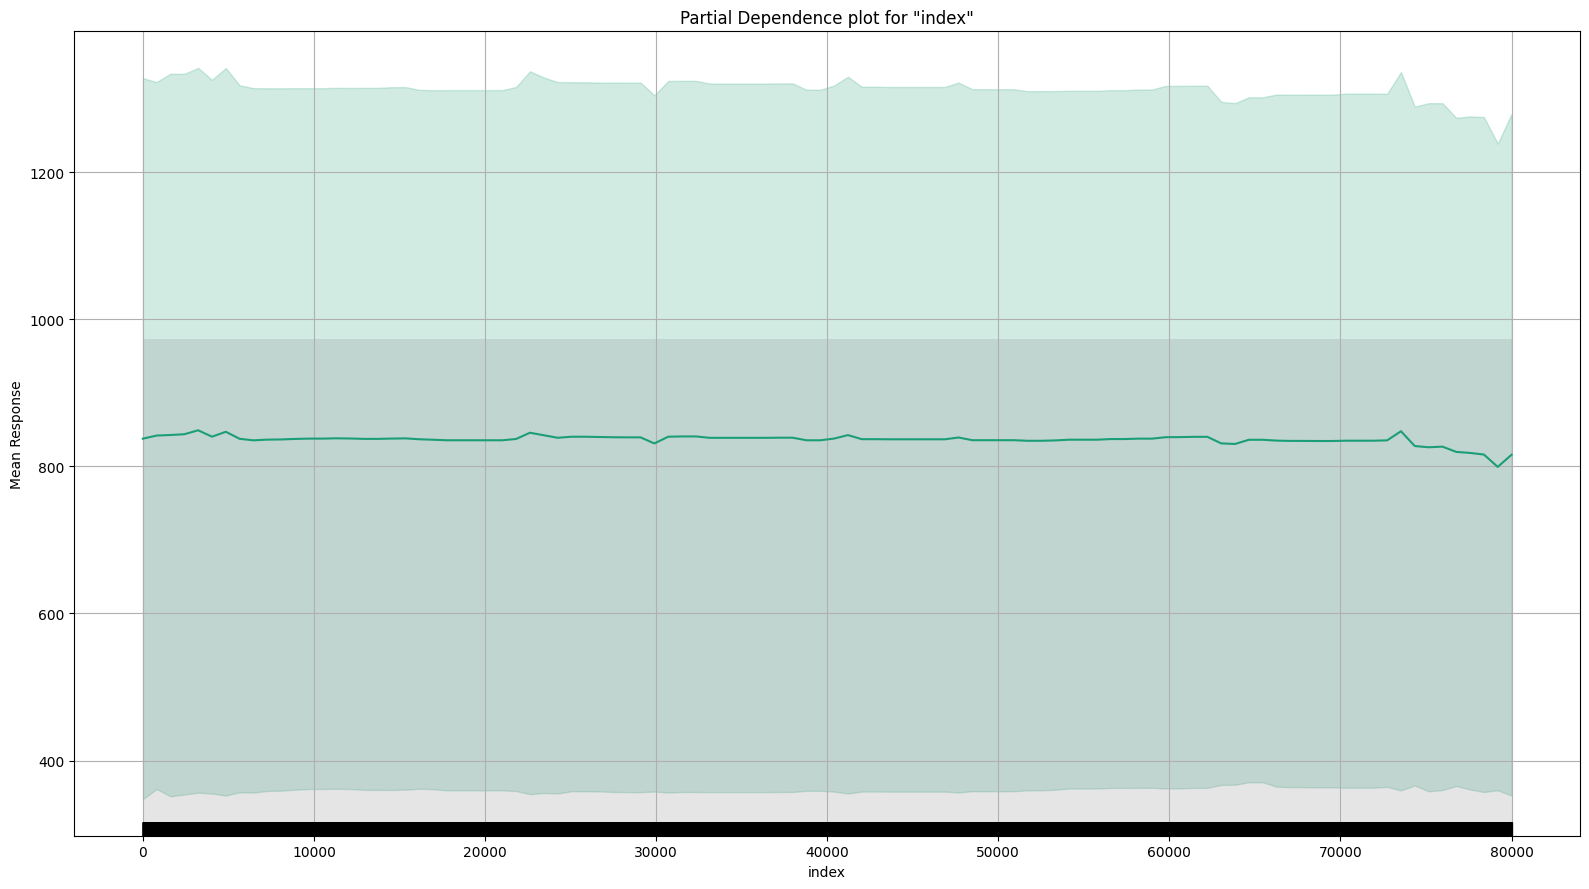

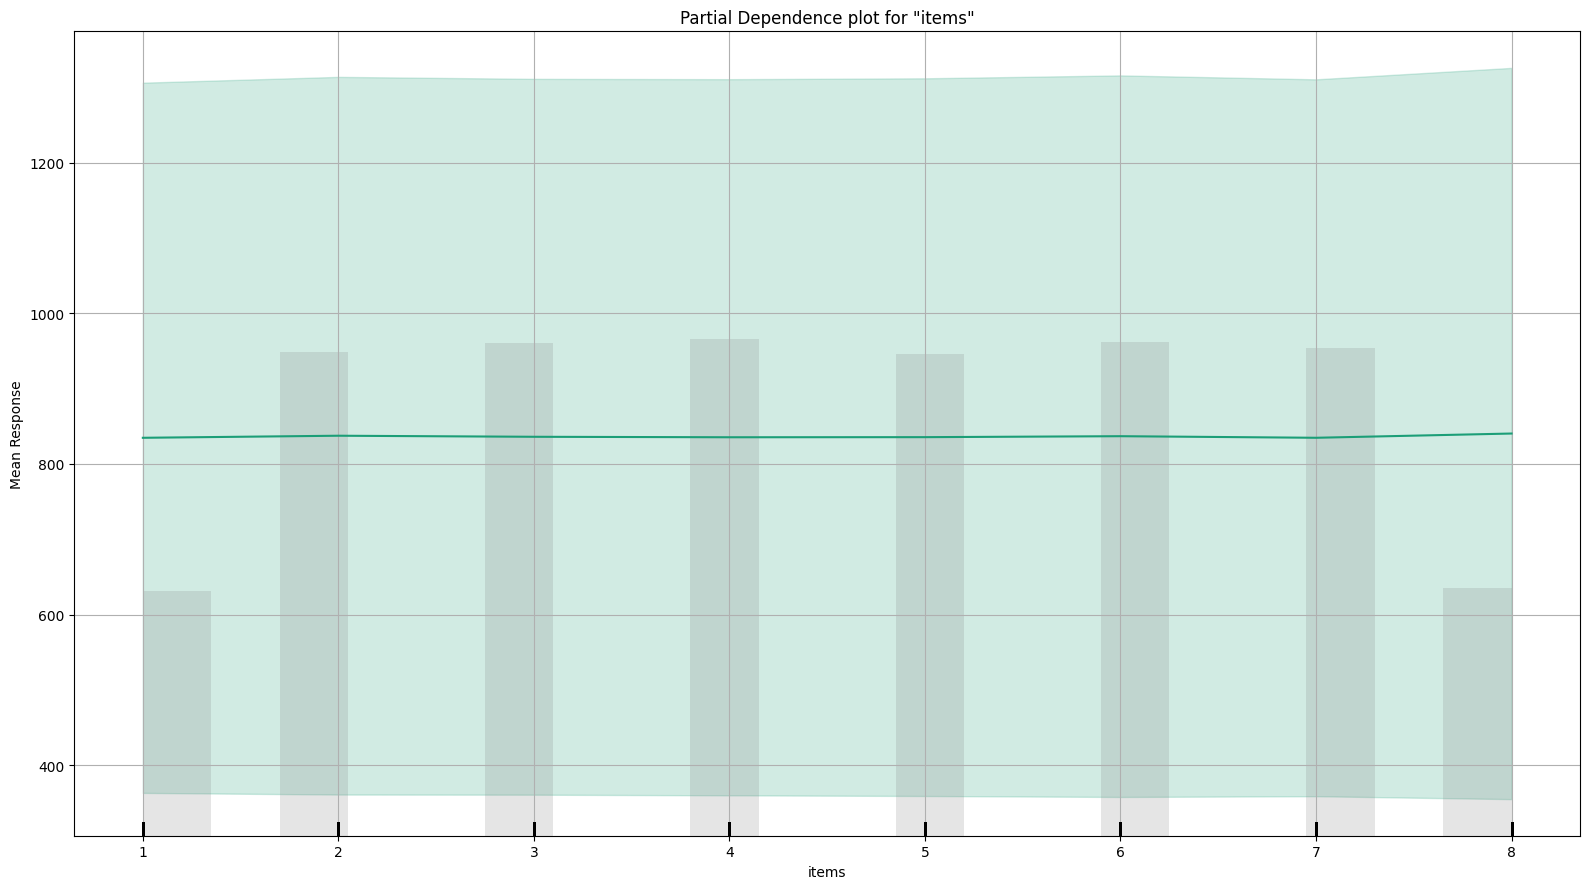

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

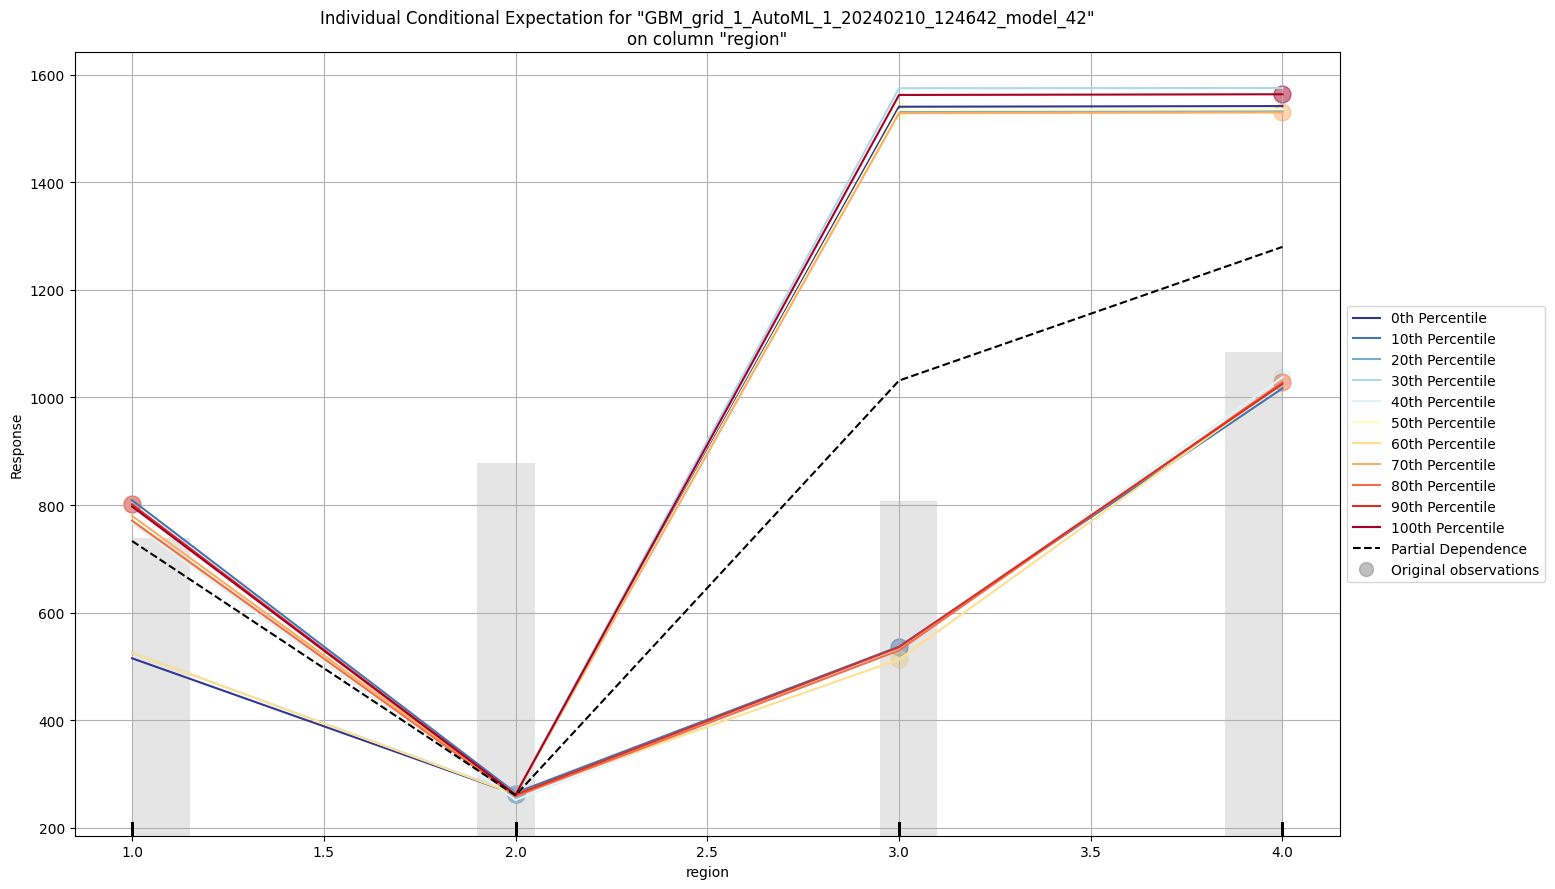

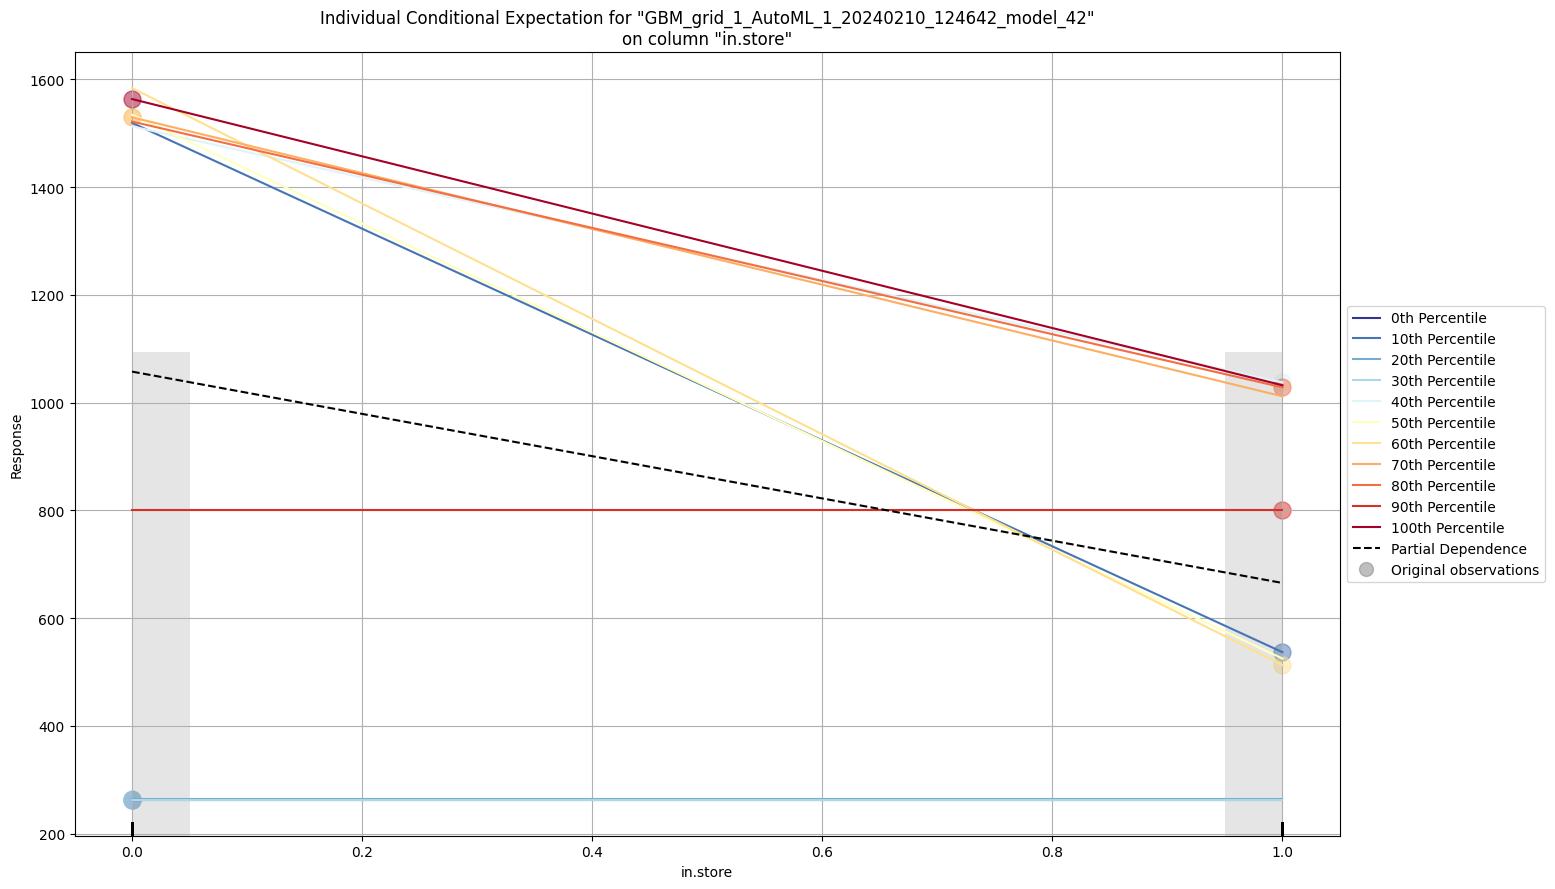

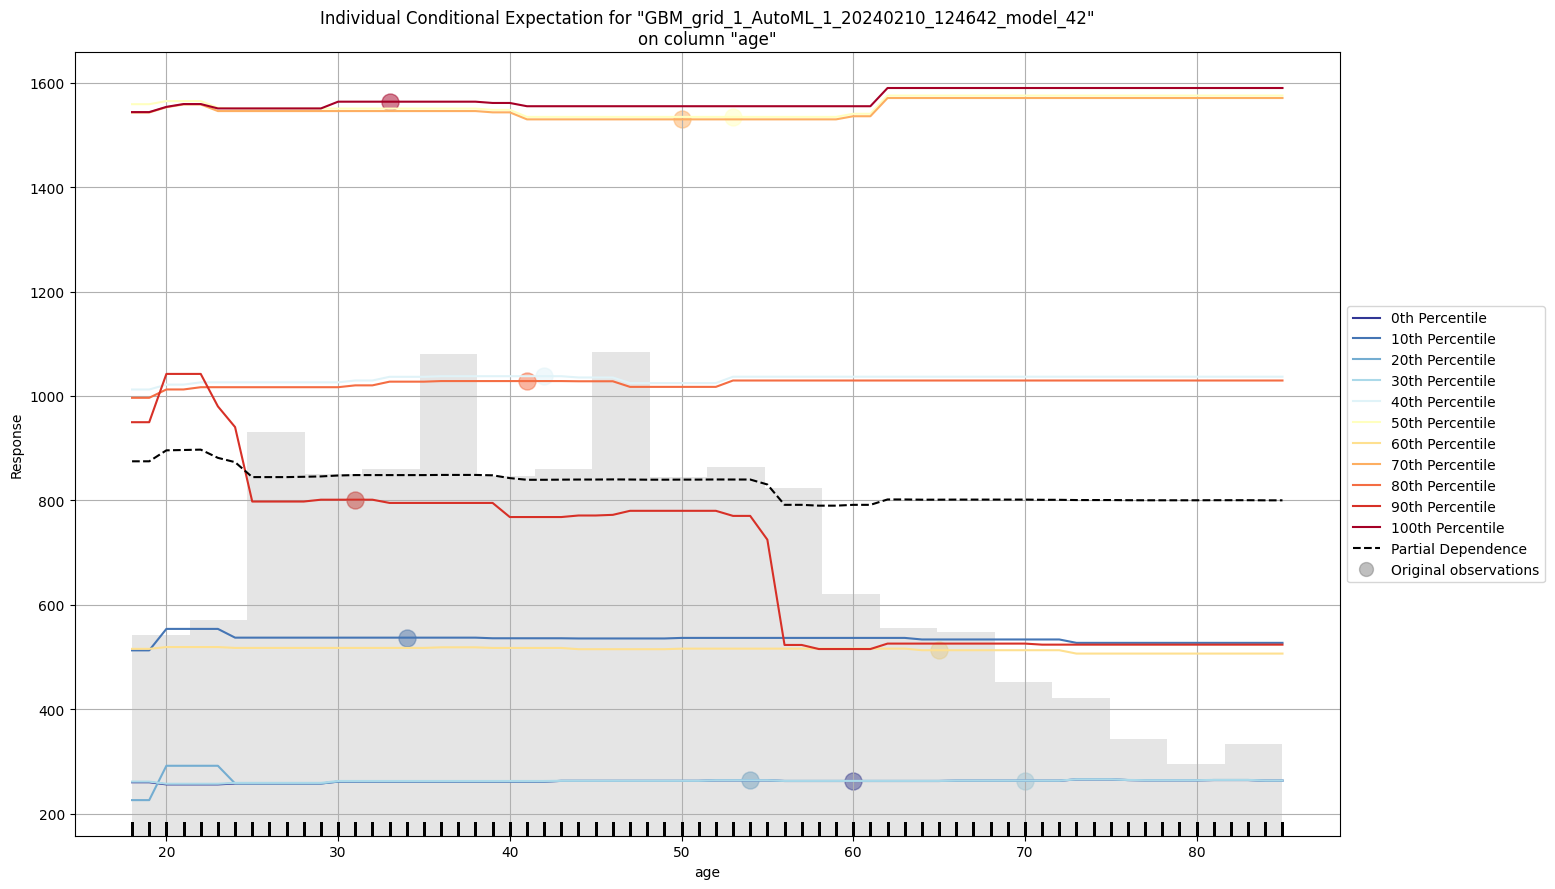

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_88b97f95bc1b5988fb44e8f5535c4a4b> was cancelled by the user.

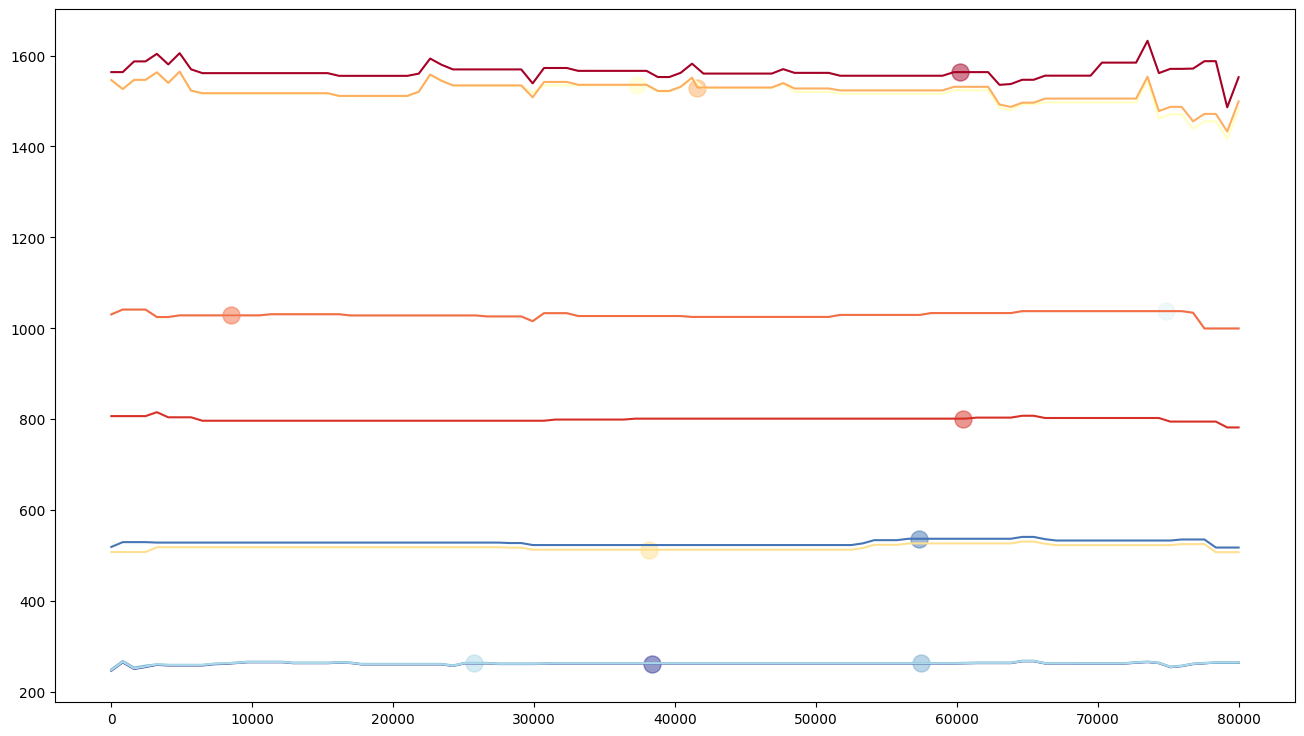

In [14]:
best_gbm_model.explain(h2o_df)

In [ ]:
%pip install shap

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import shap

# Assuming your dataset is stored in a DataFrame called 'df'
# Make sure to adjust the column names and data preparation steps accordingly

# Identify predictors and response
X = df.drop('amount', axis=1)  # Features
y = df['amount']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train GBM model
gbm_model = GradientBoostingRegressor(
    n_estimators=52,
    max_depth=6,
    min_samples_split=2,
    learning_rate=0.1,
    loss='squared_error'  # Corrected loss function name
)

gbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbm_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# Display model summary
print("Model Summary:")
print(f"Number of Trees: {gbm_model.n_estimators}")
print(f"Max Depth: {gbm_model.max_depth}")
# Add more model summary information as needed



Mean Squared Error on Test Set: 287949.24703498004
Model Summary:
Number of Trees: 52
Max Depth: 6


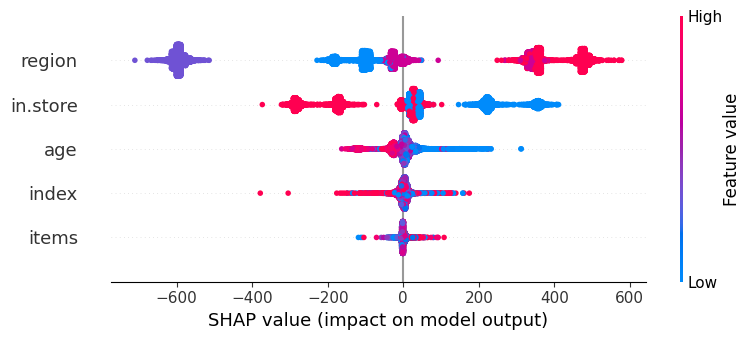

In [22]:
explainer = shap.TreeExplainer(gbm_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test)

In [21]:
import pickle
with open('gbm_model.pkl', 'wb') as model_file:
    pickle.dump(gbm_model, model_file)

In [23]:
with open('shap_explainer.pkl', 'wb') as explainer_file:
    pickle.dump(explainer, explainer_file)
